# Семинар_3: CatBoost и LightGBM

Цель семинара: освоить на практике билиотеки градиентного бустинга

План семинара:

* Посмотрим прогресс по соревнованию на Kaggle
* Практика - решим задачи по обучению моделей бустингов, рассмотрим неочевидные места.
* Подведение итогов - проанализируем и обсудим результаты

In [1]:
import phik
from phik.report import plot_correlation_matrix
from phik import report
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn import metrics

import numpy as np
from catboost import CatBoostClassifier, Pool
import pandas as pd
pd.set_option('display.max_columns', None)

# 1. Разминка CatBoost (10 минут)

Одно из самых больших удобств CatBoost - это лёгкое переключение с CPU на GPU и даже на распараллеливание на несколько GPU переключением одного гиперпараметра. 

    * Обучите 3 модели CatBoost на CPU, GPU, и 2-х GPU последовательно, замеряя время обучения.
    * Замерьте скоры, которые выдают модели.
 


In [3]:
train = pd.read_csv('/kaggle/input/seminar1/train_multiclass.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv')
train.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,target
0,0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0,3
1,1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1,6
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0,2
3,3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0,2
4,4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1,6


In [4]:
targets = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']


X = train.drop(columns=targets + ['target', 'id'])
y = train['target']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                  random_state=43, stratify=y)

# CPU

In [9]:
%%time
model = CatBoostClassifier(random_seed=43,
                           eval_metric='AUC',
                           learning_rate=0.1,
                           #iterations=2000,
                           task_type='CPU', # по умолчанию
                           thread_count=-1, # по умолчанию
                           )

model.fit(X_train, y_train, eval_set=(X_test, y_test),
          verbose=50, early_stopping_rounds=100)
print(model.get_best_score())

0:	test: 0.7906086	best: 0.7906086 (0)	total: 40.4ms	remaining: 40.3s
50:	test: 0.9128485	best: 0.9128485 (50)	total: 1.68s	remaining: 31.2s
100:	test: 0.9178482	best: 0.9178482 (100)	total: 3.29s	remaining: 29.3s
150:	test: 0.9191680	best: 0.9192460 (148)	total: 4.88s	remaining: 27.4s
200:	test: 0.9192138	best: 0.9193226 (171)	total: 6.39s	remaining: 25.4s
250:	test: 0.9194266	best: 0.9196873 (222)	total: 7.97s	remaining: 23.8s
300:	test: 0.9190907	best: 0.9197072 (259)	total: 9.57s	remaining: 22.2s
350:	test: 0.9188507	best: 0.9197072 (259)	total: 11.1s	remaining: 20.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9197071666
bestIteration = 259

Shrink model to first 260 iterations.
{'learn': {'MultiClass': 0.8046663055419903}, 'validation': {'AUC:type=Mu': 0.9197071666222232, 'MultiClass': 1.0418807856504764}}
CPU times: user 42.2 s, sys: 1.27 s, total: 43.5 s
Wall time: 11.5 s


In [10]:
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred, multi_class='ovo')

0.8619144795002696

# GPU

In [11]:
%%time
model = CatBoostClassifier(random_seed=43,
                           learning_rate=0.1,
                           eval_metric='AUC',
                           task_type='GPU',
                           thread_count=-1,
                           )

model.fit(X_train, y_train, eval_set=(X_test, y_test),
          verbose=50, early_stopping_rounds=100)
print(model.get_best_score())

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.8301189	best: 0.8301189 (0)	total: 392ms	remaining: 6m 31s
50:	test: 0.9125113	best: 0.9125113 (50)	total: 1.38s	remaining: 25.6s
100:	test: 0.9159407	best: 0.9159407 (100)	total: 2.24s	remaining: 19.9s
150:	test: 0.9172212	best: 0.9174473 (146)	total: 3.04s	remaining: 17.1s
200:	test: 0.9174668	best: 0.9175757 (195)	total: 3.93s	remaining: 15.6s
250:	test: 0.9167313	best: 0.9175757 (195)	total: 4.84s	remaining: 14.5s
bestTest = 0.9175756928
bestIteration = 195
Shrink model to first 196 iterations.
{'learn': {'MultiClass': 0.8260565289669879}, 'validation': {'AUC:type=Mu': 0.9175756927568409, 'MultiClass': 1.0471854527791342}}
CPU times: user 14.4 s, sys: 3.82 s, total: 18.2 s
Wall time: 6.29 s


In [12]:
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred, multi_class='ovo')

0.8606090499594876

# 2 x GPU

In [15]:
%%time
model = CatBoostClassifier(random_seed=43,
                           learning_rate=0.1,
                           eval_metric='AUC',
                           task_type='GPU',
                           thread_count=-1,
                           devices='0:1',
                           )

model.fit(X_train, y_train, eval_set=(X_test, y_test),
          verbose=50, early_stopping_rounds=100)
print(model.get_best_score())

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.8301189	best: 0.8301189 (0)	total: 39.1ms	remaining: 39.1s
50:	test: 0.9125113	best: 0.9125113 (50)	total: 1.3s	remaining: 24.3s
100:	test: 0.9159407	best: 0.9159407 (100)	total: 2.17s	remaining: 19.3s
150:	test: 0.9172212	best: 0.9174473 (146)	total: 3.14s	remaining: 17.7s
200:	test: 0.9174668	best: 0.9175757 (195)	total: 4.07s	remaining: 16.2s
250:	test: 0.9167313	best: 0.9175757 (195)	total: 4.95s	remaining: 14.8s
bestTest = 0.9175756928
bestIteration = 195
Shrink model to first 196 iterations.
{'learn': {'MultiClass': 0.8260565289669879}, 'validation': {'AUC:type=Mu': 0.9175756927568409, 'MultiClass': 1.0471854527791342}}
CPU times: user 15.5 s, sys: 3.59 s, total: 19.1 s
Wall time: 6.05 s


In [14]:
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred, multi_class='ovo')

0.8606090499594876

# Задача 2 (10 мин)
* Как можно заметить, даже при фиксированном `learning_rate` и сидах - метрики отличаются при смене типа ускорителя.
* Один из базовых навыков соревновательного DS - это разбираться в документации, часто не самой лучшей.
* Попробуйте найти в документации название гиперпараметра и изменить его так, чтобы скоры на CPU и GPU максимально сравнялись.
[Ссылка на нужный раздел](https://catboost.ai/en/docs/references/training-parameters/quantization)

In [16]:
model = CatBoostClassifier(random_seed=43,
                           learning_rate=0.1,
                           eval_metric='AUC',
                           task_type='GPU',
                           thread_count=-1,
                           border_count=254, # answer
                           )

model.fit(X_train, y_train, eval_set=(X_test, y_test),
          verbose=50, early_stopping_rounds=100)
print(model.get_best_score())

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.8308667	best: 0.8308667 (0)	total: 82.2ms	remaining: 1m 22s
50:	test: 0.9140920	best: 0.9140920 (50)	total: 1.37s	remaining: 25.4s
100:	test: 0.9177079	best: 0.9178944 (96)	total: 2.68s	remaining: 23.8s
150:	test: 0.9181852	best: 0.9184799 (126)	total: 3.84s	remaining: 21.6s
200:	test: 0.9183182	best: 0.9184799 (126)	total: 5.05s	remaining: 20.1s
bestTest = 0.9184798876
bestIteration = 126
Shrink model to first 127 iterations.
{'learn': {'MultiClass': 0.8719203117878305}, 'validation': {'AUC:type=Mu': 0.91847988755966, 'MultiClass': 1.0465545654296875}}


In [17]:
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred, multi_class='ovo')

0.8620332439951824

# Задача 3 (10 мин)

* Как выяснилось на прошлом семинаре, сильнее всего с таргетом коррелируют признаки `LogOfAreas` и `Log_X_Index`
* Найдите в документации как сделать из них "golden features". [ссылка](https://catboost.ai/en/docs/concepts/parameter-tuning)
* Проведите обучение, посмотрите как это повлияло на скор.
* *Зашлите сабмишен на ЛБ

In [18]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15358 entries, 9473 to 8074
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              15358 non-null  int64  
 1   X_Maximum              15358 non-null  int64  
 2   Y_Minimum              15358 non-null  int64  
 3   Y_Maximum              15358 non-null  int64  
 4   Pixels_Areas           15358 non-null  int64  
 5   X_Perimeter            15358 non-null  int64  
 6   Y_Perimeter            15358 non-null  int64  
 7   Sum_of_Luminosity      15358 non-null  int64  
 8   Minimum_of_Luminosity  15358 non-null  int64  
 9   Maximum_of_Luminosity  15358 non-null  int64  
 10  Length_of_Conveyer     15358 non-null  int64  
 11  TypeOfSteel_A300       15358 non-null  int64  
 12  TypeOfSteel_A400       15358 non-null  int64  
 13  Steel_Plate_Thickness  15358 non-null  int64  
 14  Edges_Index            15358 non-null  float64
 15  Empty

In [21]:
model = CatBoostClassifier(random_seed=43,
                           #learning_rate=0.1,
                           eval_metric='AUC',
                           task_type='GPU',
                           thread_count=-1,
                           per_float_feature_quantization=['21:border_count=1024', '22:border_count=1024'] # answer
                           )

model.fit(X_train, y_train, eval_set=(X_test, y_test),
          verbose=50, early_stopping_rounds=100)
print(model.get_best_score())

Learning rate set to 0.138564
0:	test: 0.8303165	best: 0.8303165 (0)	total: 39ms	remaining: 39s


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


50:	test: 0.9142532	best: 0.9142532 (50)	total: 1.27s	remaining: 23.6s
100:	test: 0.9164334	best: 0.9166591 (86)	total: 2.24s	remaining: 19.9s
150:	test: 0.9180481	best: 0.9180481 (150)	total: 3.19s	remaining: 17.9s
200:	test: 0.9179530	best: 0.9180481 (150)	total: 4.08s	remaining: 16.2s
250:	test: 0.9178086	best: 0.9180481 (150)	total: 4.98s	remaining: 14.9s
bestTest = 0.918048126
bestIteration = 150
Shrink model to first 151 iterations.
{'learn': {'MultiClass': 0.8058137452793332}, 'validation': {'AUC:type=Mu': 0.9180481260326515, 'MultiClass': 1.0467907587687175}}


In [22]:
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred, multi_class='ovo')

0.8605373037594476

# Задача 4 (10 мин)

* В датасете соревнования присутствует значительный дисбаланс классов
* В CatBoost есть гиперпараметры, которые позволяют бороться с дисбалансом при обучении:
    * class_weights - подается список весов для каждого класса
    * auto_class_weights - может принимать 2 значения (по умолчанию None)
    * scale_pos_weight - применяется в задачах бинарной классификации для указания веса положительного класса
* Проведите обучение с различным значением параметра `auto_class_weights`, как это влияет на скор?
* *Зашлите сабмишен на ЛБ

In [25]:
model = CatBoostClassifier(random_seed=43,
                           learning_rate=0.1,
                           eval_metric='AUC',
                           task_type='GPU',
                           thread_count=-1,
                           auto_class_weights='Balanced',# code hear
                           )

model.fit(X_train, y_train, eval_set=(X_test, y_test),
          verbose=50, early_stopping_rounds=100)
print(model.get_best_score())

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.8451786	best: 0.8451786 (0)	total: 22.9ms	remaining: 22.9s
50:	test: 0.9172979	best: 0.9172979 (50)	total: 1.57s	remaining: 29.2s
100:	test: 0.9195798	best: 0.9195798 (100)	total: 2.58s	remaining: 23s
150:	test: 0.9190753	best: 0.9198178 (125)	total: 3.42s	remaining: 19.3s
200:	test: 0.9189501	best: 0.9198178 (125)	total: 4.27s	remaining: 17s
bestTest = 0.9198178122
bestIteration = 125
Shrink model to first 126 iterations.
{'learn': {'MultiClass': 0.7476787042180333}, 'validation': {'AUC:type=Mu': 0.9198178121903913, 'MultiClass': 1.118721705586104}}


In [26]:
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred, multi_class='ovo')

0.8754041142555612

In [27]:
# подготовка файла для сабмишена
submission = pd.DataFrame(
    model.predict_proba(test.drop(columns=['id']))[:, :-1],
    columns=targets,
    index=test.id
).reset_index()
submission.to_csv('submission.csv', index=False)
submission.head(5)

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.615667,0.011462,0.001492,0.000246,0.086018,0.073049,0.128226
1,19220,0.207422,0.009337,0.002807,0.000919,0.632972,0.035957,0.068117
2,19221,0.004876,0.116426,0.051879,0.004402,0.025039,0.215654,0.217746
3,19222,0.294717,0.007335,0.001657,0.016245,0.055986,0.257771,0.248110
4,19223,0.006807,0.005624,0.002433,0.016908,0.056751,0.558354,0.229149


# LightGBM
## Самый быстрый
### 1. Разминка (10 мин)
* Обучить LightGBM, определить время обучения и скор
* Посмотреть Feature importance
* LightGBM поддерживает несколько алгоритмов градиентного бустинга (параметр `boosting_type`):
    
    * gbdt - градиеный бустинг над решающими деревьями (используется по умолчанию);
    * dart - понятие отсева (dropout) вводится в MART, получаем [DART](https://arxiv.org/abs/1505.01866) (как dropout слой в нейронках);
    * goss - односторонняя выборка на основе градиента (GOSS).
* Обучите LightGBM в остальных 2-х режимах, проверьте в каком режиме скор выше.

In [28]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [29]:
%%time
model = LGBMClassifier(random_state=43,
        objective="multiclass",
        n_estimators=1000,
        num_class=7,
        n_jobs=-1,
)

model.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        callbacks=[lgb.early_stopping(stopping_rounds=50)],
    )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5200
[LightGBM] [Info] Number of data points in the train set: 15358, number of used features: 27
[LightGBM] [Info] Start training from score -2.572925
[LightGBM] [Info] Start training from score -2.815018
[LightGBM] [Info] Start training from score -1.727701
[LightGBM] [Info] Start training from score -3.521295
[LightGBM] [Info] Start training from score -3.678386
[LightGBM] [Info] Start training from score -1.394270
[LightGBM] [Info] Start training from score -1.076843
[LightGBM] [Info] Start training from score -3.156284
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's multi_logloss: 1.06599
CPU times: user 8.04 s, sys: 105 ms, total: 8.14 s
Wall time: 2.09 s


LGBMClassifier(n_estimators=1000, n_jobs=-1, num_class=7,
               objective='multiclass', random_state=43)

In [30]:
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred, multi_class='ovo')

0.8554545880034186

## Feature importance
У данного метода есть параметр `importance_type`. Если он установлен в значение `split`, то график будет отображать количество раз, которое каждый показатель использовался для разбиения. Если установлено значение `gain`, то будет показан выигрыш от соответствующих разделений. Значение параметра `importance_type` по умолчанию `split`.

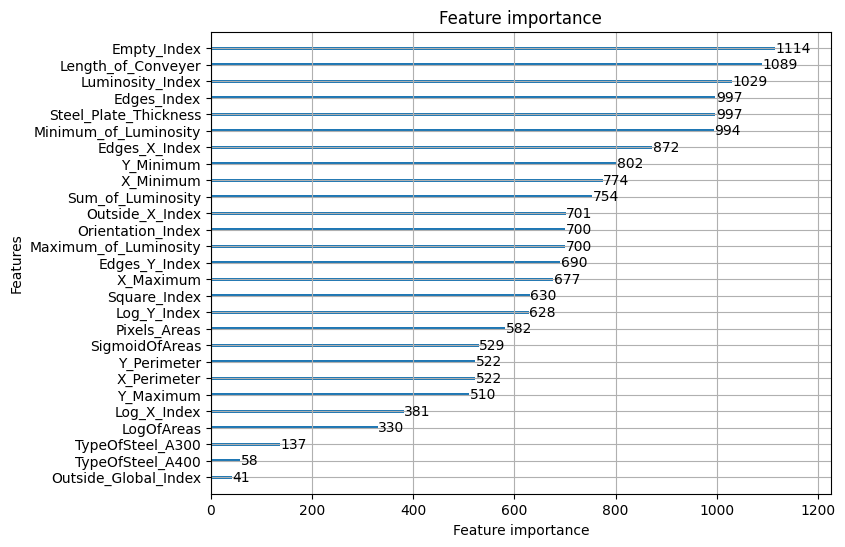

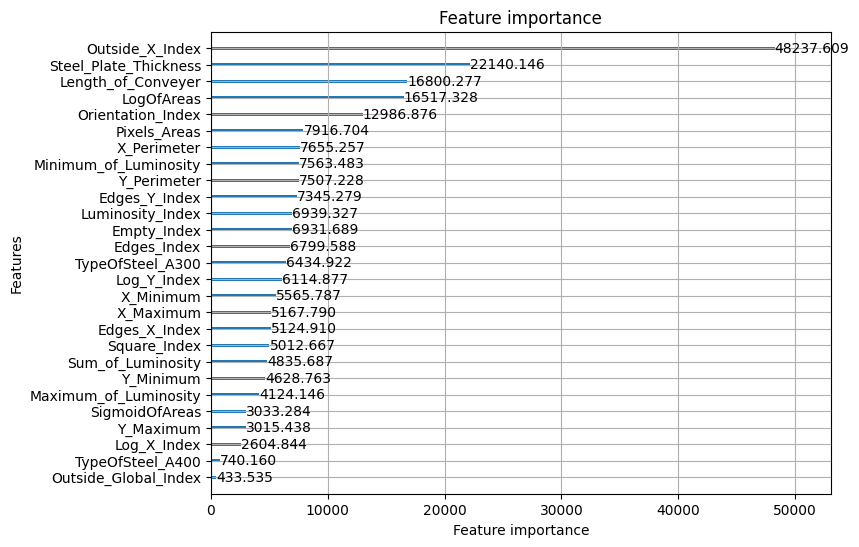

In [48]:
lgb.plot_importance(model, figsize=(8, 6), importance_type="split")
lgb.plot_importance(model, figsize=(8, 6), importance_type="gain");

# GOSS

In [32]:
model = LGBMClassifier(random_state=43,
                        objective="multiclass",
                        #n_estimators=1000,
                        num_class=7,
                        n_jobs=-1,
                        boosting_type='goss',
                        data_sample_strategy='goss',
    )
    
model.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        callbacks=[lgb.early_stopping(stopping_rounds=50)],
    )

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5200
[LightGBM] [Info] Number of data points in the train set: 15358, number of used features: 27
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Start training from score

LGBMClassifier(boosting_type='goss', data_sample_strategy='goss', n_jobs=-1,
               num_class=7, objective='multiclass', random_state=43)

In [33]:
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred, multi_class='ovo')

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


0.8415018483596918

# DART

In [34]:
model = LGBMClassifier(random_state=43,
                        objective="multiclass",
                        #n_estimators=1000,
                        num_class=7,
                        n_jobs=-1,
                        boosting_type='dart'
    )
    
model.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        callbacks=[lgb.early_stopping(stopping_rounds=50)],
    )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5200
[LightGBM] [Info] Number of data points in the train set: 15358, number of used features: 27
[LightGBM] [Info] Start training from score -2.572925
[LightGBM] [Info] Start training from score -2.815018
[LightGBM] [Info] Start training from score -1.727701
[LightGBM] [Info] Start training from score -3.521295
[LightGBM] [Info] Start training from score -3.678386
[LightGBM] [Info] Start training from score -1.394270
[LightGBM] [Info] Start training from score -1.076843
[LightGBM] [Info] Start training from score -3.156284


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


LGBMClassifier(boosting_type='dart', n_jobs=-1, num_class=7,
               objective='multiclass', random_state=43)

In [35]:
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred, multi_class='ovo')

0.8568336356865037

## Задача 2 (5 мин)
* В LightGBM так же присутствует гиперпараметр, позволяющий учитывать дисбаланс классов: `is_unbalance`
* Найдите его описание в [документации LightGBM](https://lightgbm.readthedocs.io/en/latest/Parameters.html#core-parameters)
* Проведите эксперимент с этим параметром, посмотрите как изменился скор
* *Отправьте сабмишн на ЛБ


In [42]:
model = LGBMClassifier(random_state=43,
        objective="multiclass",
        n_estimators=1000,
        num_class=7,
        n_jobs=-1,
        is_unbalance=True,
                       
)

model.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        callbacks=[lgb.early_stopping(stopping_rounds=50)],
    )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5200
[LightGBM] [Info] Number of data points in the train set: 15358, number of used features: 27
[LightGBM] [Info] Start training from score -2.572925
[LightGBM] [Info] Start training from score -2.815018
[LightGBM] [Info] Start training from score -1.727701
[LightGBM] [Info] Start training from score -3.521295
[LightGBM] [Info] Start training from score -3.678386
[LightGBM] [Info] Start training from score -1.394270
[LightGBM] [Info] Start training from score -1.076843
[LightGBM] [Info] Start training from score -3.156284
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's multi_logloss: 1.06599


LGBMClassifier(is_unbalance=True, n_estimators=1000, n_jobs=-1, num_class=7,
               objective='multiclass', random_state=43)

In [43]:
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred, multi_class='ovo')

0.8554545880034186

In [39]:
# подготовка файла для сабмишена
submission = pd.DataFrame(
    model.predict_proba(test.drop(columns=['id']))[:, :-1],
    columns=targets,
    index=test.id
).reset_index()
submission.to_csv('submission.csv', index=False)
submission.head(5)

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.415807,0.002897,0.006396,0.000870,0.023439,0.188691,0.325957
1,19220,0.446459,0.010615,0.010373,0.000666,0.117819,0.084778,0.295959
2,19221,0.002722,0.026453,0.040165,0.001132,0.003666,0.294234,0.544947
3,19222,0.135507,0.002681,0.004661,0.000882,0.007878,0.405398,0.412562
4,19223,0.003536,0.002030,0.003549,0.000713,0.003857,0.569448,0.382338


# Задача 3 (15 мин)
* В LightGBM реализована возможность использовать шэдулер при обуении для плавного понижения learning rate, как при обучении нейросетей
* Scheduler реализован на базе callback функции reset_parameter()
* Попробуйте обучить модель, используя шэдулер, проанализируйте результаты
* Поэкспериментируйте с порогами learning_rate и числом итераций

In [57]:
n_estimators = 200

model = LGBMClassifier(random_state=43,
        objective="multiclass",
        n_estimators=n_estimators,
        num_class=7,
        n_jobs=-1,
                       
)

model.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                  lgb.reset_parameter(learning_rate=np.linspace(0.05, 0.008, n_estimators).tolist())],
    )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5200
[LightGBM] [Info] Number of data points in the train set: 15358, number of used features: 27
[LightGBM] [Info] Start training from score -2.572925
[LightGBM] [Info] Start training from score -2.815018
[LightGBM] [Info] Start training from score -1.727701
[LightGBM] [Info] Start training from score -3.521295
[LightGBM] [Info] Start training from score -3.678386
[LightGBM] [Info] Start training from score -1.394270
[LightGBM] [Info] Start training from score -1.076843
[LightGBM] [Info] Start training from score -3.156284
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[96]	valid_0's multi_logloss: 1.05458


LGBMClassifier(n_estimators=200, n_jobs=-1, num_class=7, objective='multiclass',
               random_state=43)

In [58]:
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred, multi_class='ovo')

0.8592269746271832

In [46]:
np.linspace(0.1, 0.01, n_estimators)

array([0.1       , 0.09909091, 0.09818182, 0.09727273, 0.09636364,
       0.09545455, 0.09454545, 0.09363636, 0.09272727, 0.09181818,
       0.09090909, 0.09      , 0.08909091, 0.08818182, 0.08727273,
       0.08636364, 0.08545455, 0.08454545, 0.08363636, 0.08272727,
       0.08181818, 0.08090909, 0.08      , 0.07909091, 0.07818182,
       0.07727273, 0.07636364, 0.07545455, 0.07454545, 0.07363636,
       0.07272727, 0.07181818, 0.07090909, 0.07      , 0.06909091,
       0.06818182, 0.06727273, 0.06636364, 0.06545455, 0.06454545,
       0.06363636, 0.06272727, 0.06181818, 0.06090909, 0.06      ,
       0.05909091, 0.05818182, 0.05727273, 0.05636364, 0.05545455,
       0.05454545, 0.05363636, 0.05272727, 0.05181818, 0.05090909,
       0.05      , 0.04909091, 0.04818182, 0.04727273, 0.04636364,
       0.04545455, 0.04454545, 0.04363636, 0.04272727, 0.04181818,
       0.04090909, 0.04      , 0.03909091, 0.03818182, 0.03727273,
       0.03636364, 0.03545455, 0.03454545, 0.03363636, 0.03272